<a href="https://colab.research.google.com/github/daffayrr/Intel-AI-Global-Impact-Festival-2023/blob/main/Brain_MRI_Detection_for_Tumor_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:00<00:00, 59.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 86.6MB/s]


In [ ]:
! unzip /content/brain-mri-images-for-brain-tumor-detection.zip

Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tum

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
base_dir = '/content/brain_tumor_dataset'
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

print('total have tumor images:', len(os.listdir(yes_dir)))
print('total no tumor images:', len(os.listdir(no_dir)))

total have tumor images: 155
total no tumor images: 98


In [ ]:
yes_files = os.listdir(yes_dir)
print(yes_files[:10])

no_files = os.listdir(no_dir)
print(no_files[:10])

['Y19.JPG', 'Y79.jpg', 'Y47.JPG', 'Y78.jpg', 'Y167.JPG', 'Y21.jpg', 'Y188.jpg', 'Y35.jpg', 'Y108.jpg', 'Y15.jpg']
['No13.jpg', '21 no.jpg', 'no 7.jpeg', 'no 6.jpg', '13 no.jpg', 'N26.JPG', '28 no.jpg', '43 no.jpg', 'N17.jpg', '26 no.jpg']


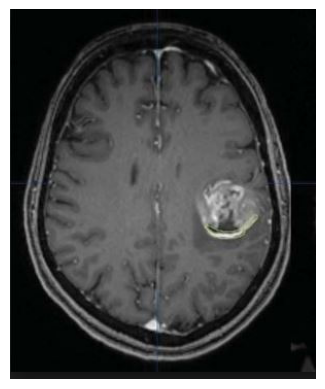

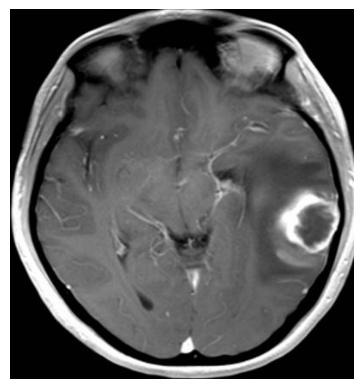

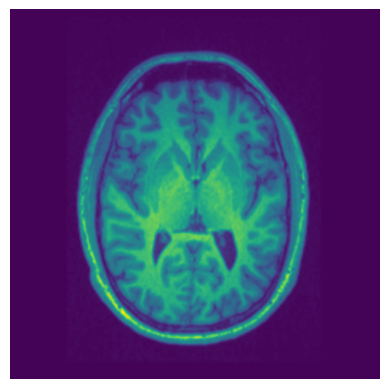

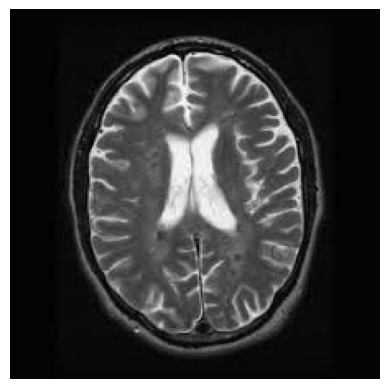

In [ ]:
%matplotlib inline

pic_index = 2

next_yes = [os.path.join(yes_dir, fname)
                for fname in yes_files[pic_index-2:pic_index]]
next_no = [os.path.join(no_dir, fname)
                for fname in no_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_yes+next_no):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [ ]:
dataset=[]
target=[]
for image_name in yes_files:
    image=cv2.imread(yes_dir + '/' +image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(1)

for image_name in no_files:
    image=cv2.imread(no_dir + '/' + image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(0)

In [ ]:
data = np.array(dataset)
target = np.array(target)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,target,test_size=0.05,random_state=True)

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE

    return data_augmentation

def preprocess_data(X):
    X_p = tf.keras.applications.resnet50.preprocess_input(X)
    return X_p

In [ ]:
def resnet_model(X, augmentation=data_augmenter()):
    '''
    classification model
    '''

#     input_shape = X[0].shape

    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)

    model.trainable = False

    inputs = tf.keras.Input(shape=X[0].shape)

    x = augmentation(inputs)

    x = preprocess_data(x)

    x = model(x, training= False)

    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.4)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)

    outputs = prediction_layer(x)
    mod = tf.keras.Model(inputs, outputs)

    return mod

In [ ]:
resNet = resnet_model(X_train, augmentation=data_augmenter())

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
base_learning_rate = 0.0001
resNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 50
history = resNet.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50
8/8 [==============================] - 11s 670ms/step - loss: 2.0389 - accuracy: 0.4292 - val_loss: 1.4130 - val_accuracy: 0.4615
Epoch 2/50
8/8 [==============================] - 5s 648ms/step - loss: 1.9772 - accuracy: 0.4208 - val_loss: 1.2472 - val_accuracy: 0.2308
Epoch 3/50
8/8 [==============================] - 4s 497ms/step - loss: 1.7424 - accuracy: 0.4792 - val_loss: 1.1888 - val_accuracy: 0.1538
Epoch 4/50
8/8 [==============================] - 7s 710ms/step - loss: 1.4269 - accuracy: 0.5542 - val_loss: 1.1117 - val_accuracy: 0.3077
Epoch 6/50
8/8 [==============================] - 4s 470ms/step - loss: 1.2538 - accuracy: 0.5958 - val_loss: 1.0490 - val_accuracy: 0.3846
Epoch 7/50
8/8 [==============================] - 4s 531ms/step - loss: 1.5734 - accuracy: 0.5417 - val_loss: 0.9827 - val_accuracy: 0.3077
Epoch 8/50
8/8 [==============================] - 7s 818ms/step - loss: 1.1859 - accuracy: 0.6333 - val_loss: 0.9182 - val_accuracy: 0.4615
Epoch 9/50
8/8 [===

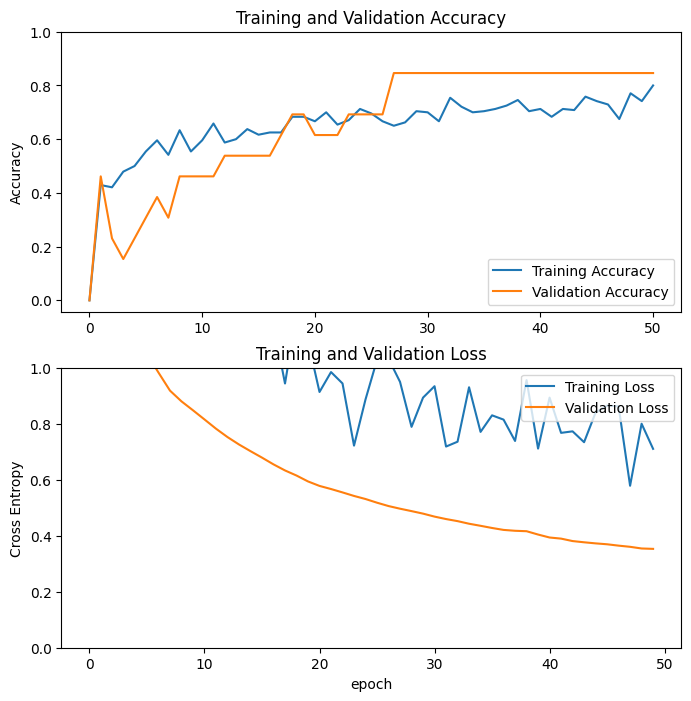

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def resnet_model_2(X, augmentation=data_augmenter()):
    '''
    classification model
    '''

#     input_shape = X[0].shape

    model_2 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)

    # Fine-tune from this layer onwards
    fine_tune_at = 165


    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model_2.layers[:fine_tune_at]:
        #print('Layer ' + layer.name + ' frozen.')
        layer.trainable = False

    inputs = tf.keras.Input(shape=X[0].shape)

    x = augmentation(inputs)

    x = preprocess_data(x)

    x = model_2(x)

    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.6)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1,activation="sigmoid")

    outputs = prediction_layer(x)
    mod_2 = tf.keras.Model(inputs, outputs)

    return mod_2

In [ ]:
resNet_2 = resnet_model_2(X_train, augmentation=data_augmenter())

In [ ]:
resNet_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
resNet_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 50
history_2 = resNet_2.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 20s 2s/step - loss: 1.2683 - accuracy: 0.5833 - val_loss: 0.6001 - val_accuracy: 0.6923
Epoch 2/50
8/8 [==============================] - 11s 1s/step - loss: 0.7753 - accuracy: 0.6833 - val_loss: 0.3931 - val_accuracy: 0.7692
Epoch 3/50
8/8 [==============================] - 10s 1s/step - loss: 0.6891 - accuracy: 0.7083 - val_loss: 0.3428 - val_accuracy: 0.7692
Epoch 4/50
8/8 [==============================] - 10s 1s/step - loss: 0.7028 - accuracy: 0.7542 - val_loss: 0.2927 - val_accuracy: 0.8462
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.6591 - accuracy: 0.7708 - val_loss: 0.2219 - val_accuracy: 0.9231
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.5229 - accuracy: 0.8083 - val_loss: 0.1829 - val_accuracy: 0.9231
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.5399 - accuracy: 0.8250 - val_loss: 0.1948 - val_accuracy: 0.9231
Epoch 8/50
8/8 [=============================

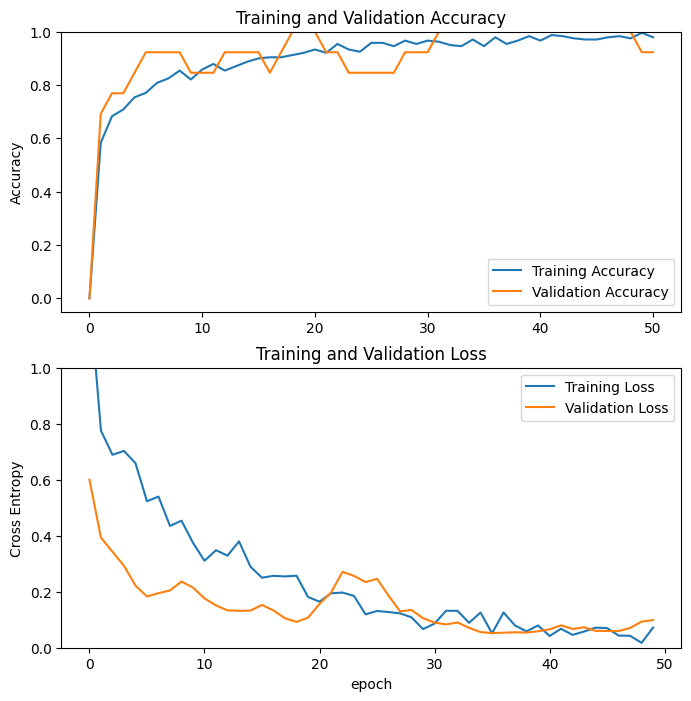

In [ ]:
acc = [0.] + history_2.history['accuracy']
val_acc = [0.] + history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model = resNet_2
model.save("resNet Model 2.h5")